In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, svm, ensemble

In [2]:
%matplotlib inline

# Exploration

Binary dataset, 564 of class 1 and 282 of class 2, together 846

1    564
2    282
Name: Class, dtype: int64


([<matplotlib.axis.XTick at 0x192dd0b7940>,
 [Text(0, 0, 'Class 1'), Text(1, 0, 'Class 2')])

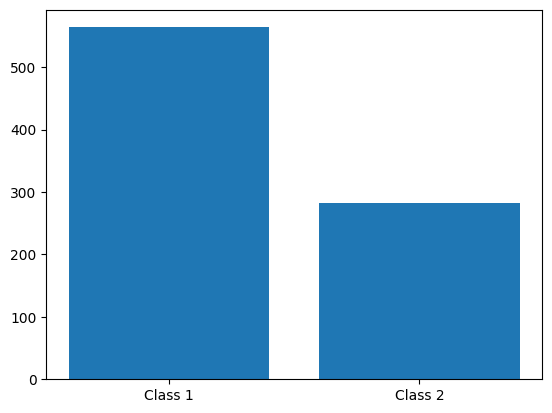

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.sample()
df.loc[:, "V1":"V3"]
classes = df.loc[:, "Class"].value_counts()
#print(classes, sum(classes))
y_pos = np.arange(len(classes), step=1)
print(classes)
plt.bar(y_pos, classes)
plt.xticks(y_pos, {"Class 1", "Class 2"})

In [4]:
#any(df.isnull())    # Missing values

#df.isnull().sum()
df_test = df_test.fillna(df.mean())
df = df.fillna(df.mean())   # Fill missing values with the mean values
#df.loc[:, "Class"]

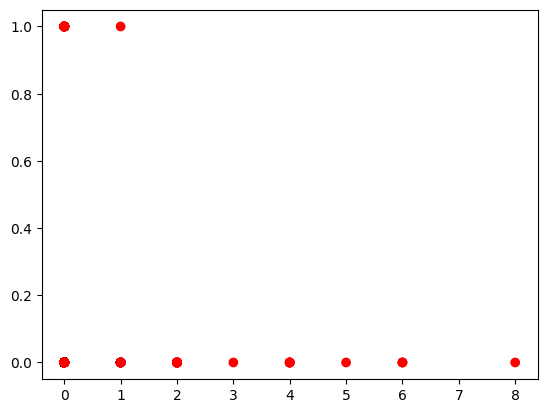

In [5]:
colors = ["red" if c == 1 else "blue" for c in df["Class"]]
labels = ["Class1" if c == 1 else "Class 2" for c in df["Class"]]
plt.scatter(x=df.loc[:,"V32"], y=df.loc[:,"V24"], c=colors)

Text(0.5, 0.98, 'Pairs of features, colored by the class')

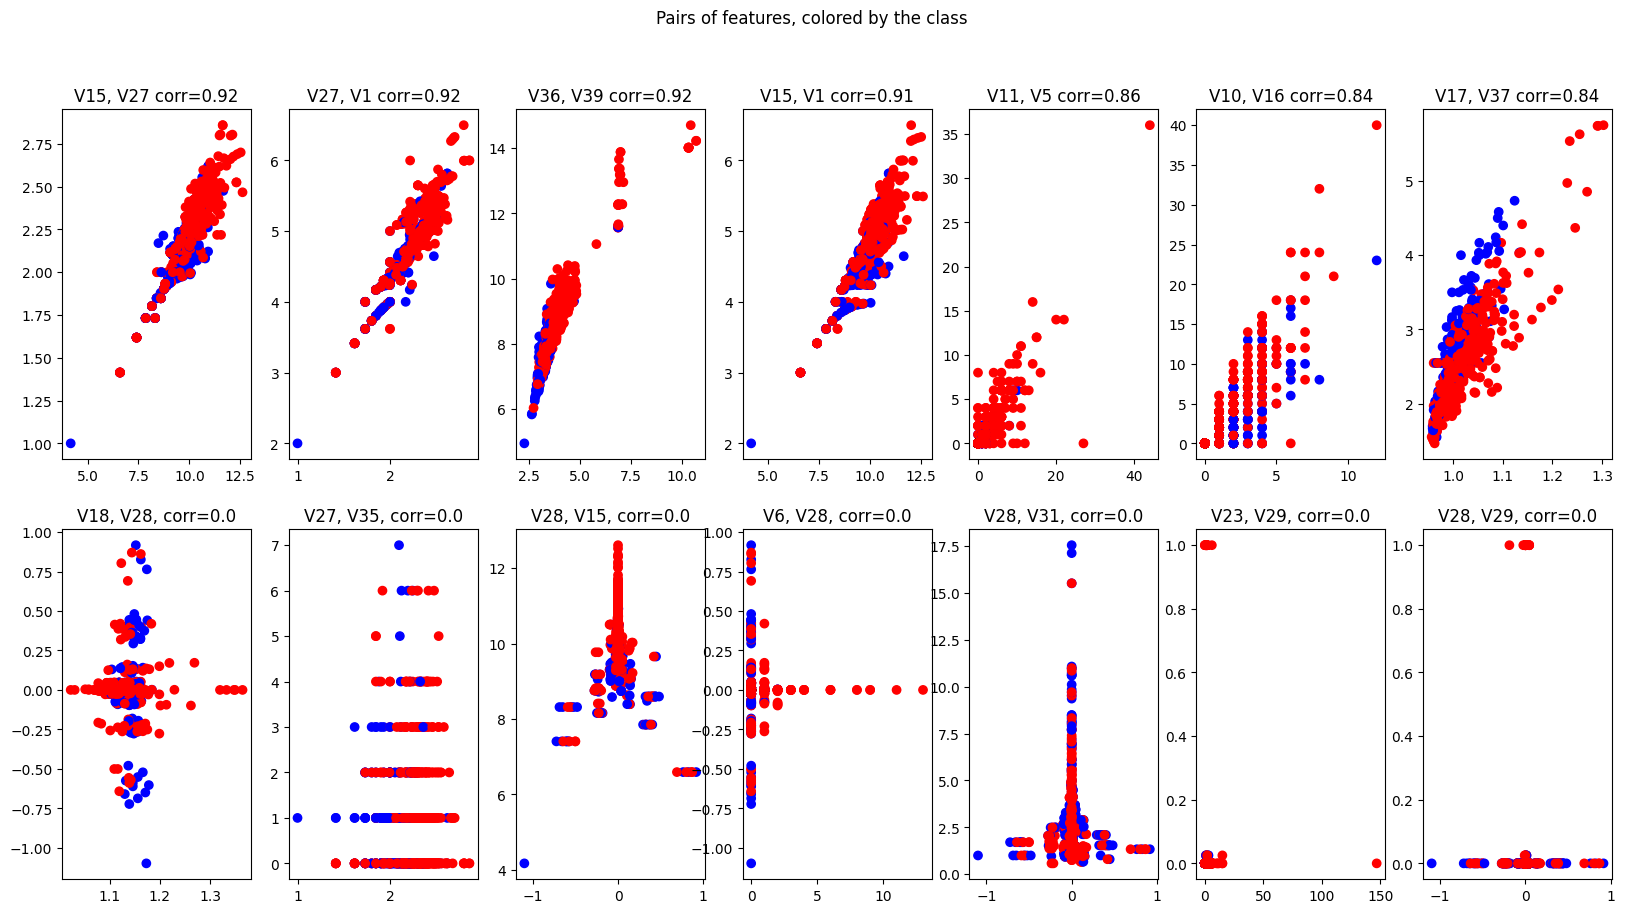

In [6]:
corr = abs(df.corr())   # Only need the magnitude

#corr = np.array(corr)   # Convert to numpy array
#corr = corr[~np.eye(corr.shape[0], dtype=bool)].reshape(corr.shape[0], -1)  # Remove diagonal elements
#corr = pd.DataFrame(corr) # Convert back to dataframe

corr = corr.unstack().sort_values(ascending=False)  # Convert to Series and sort

corr = corr.reset_index()   # Reset labels
corr.columns = ["feature1", "feature2", "corr"] # Rename labels

fig, ax = plt.subplots(2,7, figsize=(20,10))

displayed = set()

n = 0
for i in range(len(corr)):
    if n == 7:
        break
    pair = corr.iloc[i]
    if pair[0] and pair[1] and pair[0] != pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[0,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with highest correlations
        ax[0,n].set_title(f"{pair[0]}, {pair[1]} corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))
        n += 1

n = 0
for i in range(len(corr)):
    if n >= 7:
        break
    
    pair = corr[::-1].iloc[i]
    if pair[0] and pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
        ax[1,n].scatter(x=df[pair[0]], y=df[pair[1]], c=colors, label=labels)  # Display pairs with lowest correlations
        ax[1,n].set_title(f"{pair[0]}, {pair[1]}, corr={round(pair[2], 2)}")
        
        displayed.add((pair[0], pair[1]))        
        n += 1
        
fig.suptitle("Pairs of features, colored by the class")

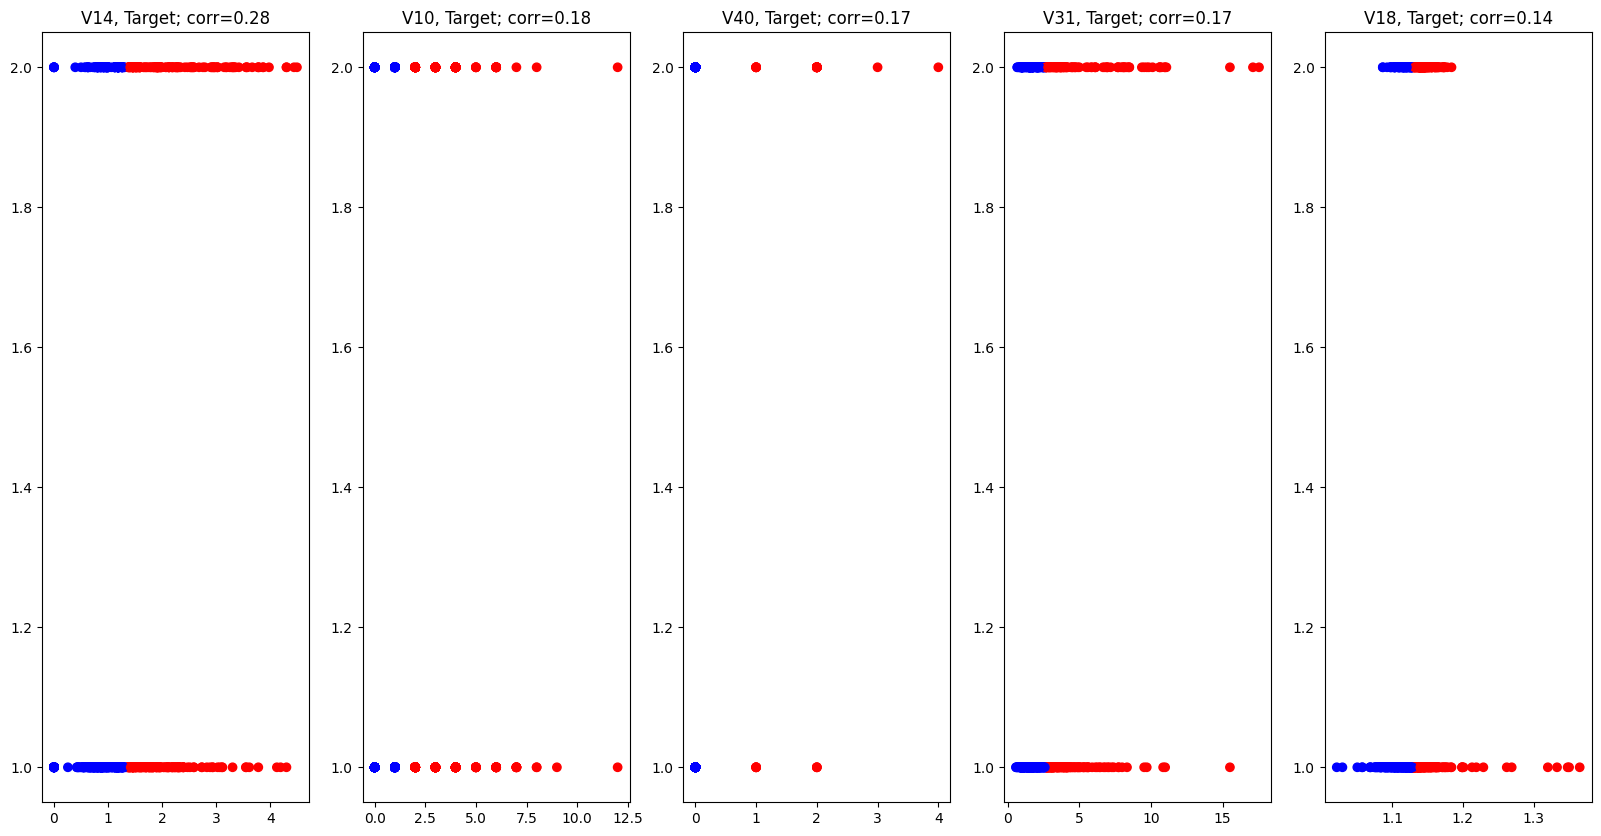

In [7]:
# Get correlation of each feature to the target class and plot the ones with highest correlation
fig, ax = plt.subplots(1,5, figsize=(20,10))

target_corr = df.corr()
pairs = []

for i in range(len(target_corr)-1):
    pairs.append((f"V{i+1}", target_corr.iloc[i,-1]))

pairs = sorted(pairs, key=lambda x: x[1])
pairs = pairs[::-1]

def get_colors(feature: str) -> np.ndarray:
    '''
        Colors the points based on their value compared to the mean
    '''
    mean = np.mean(df[feature])
    target_colors = ["red" if f > mean else "blue" for f in df[feature]]
    return target_colors
    
     

for i in range(5):
    ax[i].scatter(x=df.loc[:,pairs[i][0]], y=df.loc[:,"Class"], label=pairs[i][0], c=get_colors(pairs[i][0]))
    ax[i].set_title(f"{pairs[i][0]}, Target; corr={round(pairs[i][1], 2)}")
        
    

## TODO
* Feature selection
* ML models on all features and different subsets
* Feature transformations
* Result evaluation

# Modeling

### Majority classifier

In [8]:
class MajorityClassifier:
    '''
        Classifies the class with the majority classifier. Constructor takes in a pandas dataframe
    '''
    
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return self.df["Class"].mode()[0]
        

In [9]:
mc = MajorityClassifier(df)
mc.fit()

1

### Random classifier

In [10]:
class RandomClassifier:
    '''
        Classifies the class randomly. Constructor takes in a pandas dataframe
    '''
    def __init__(self, df):
        self.df = df
        
    def fit(self):
        return np.random.choice(self.df["Class"].values)

In [11]:
rc = RandomClassifier(df)
rc.fit()

2

### KNN - K Nearest Neighbors Model

In [12]:
# https://scikit-learn.org/stable/modules/neighbors.html
class KNeighbors:
    '''
        K Nearest Neigbors. Constructor takes in the train and test dataframe
    '''
    def __init__(self, train_df, test_df, n_neighbors=5):
        self.train_df = train_df
        self.test_df = test_df
        self.n_neighbors = n_neighbors
        
    def fit(self, n_neighbors=5, weights="uniform", metric="minkowski"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
                
        # Get KNN object and fit the data
        clf = neighbors.KNeighborsClassifier(self.n_neighbors, weights=weights, metric=metric)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        return clf, accuracy
    
    def filter_features(self):
        return

In [64]:
knn = KNeighbors(df, df_test, 3)
clf, knn_accuracy = knn.fit(n_neighbors=5)
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

KNN accuracy:  75.598%


KNN prediction plot

Text(0.5, 1.0, 'Diff')

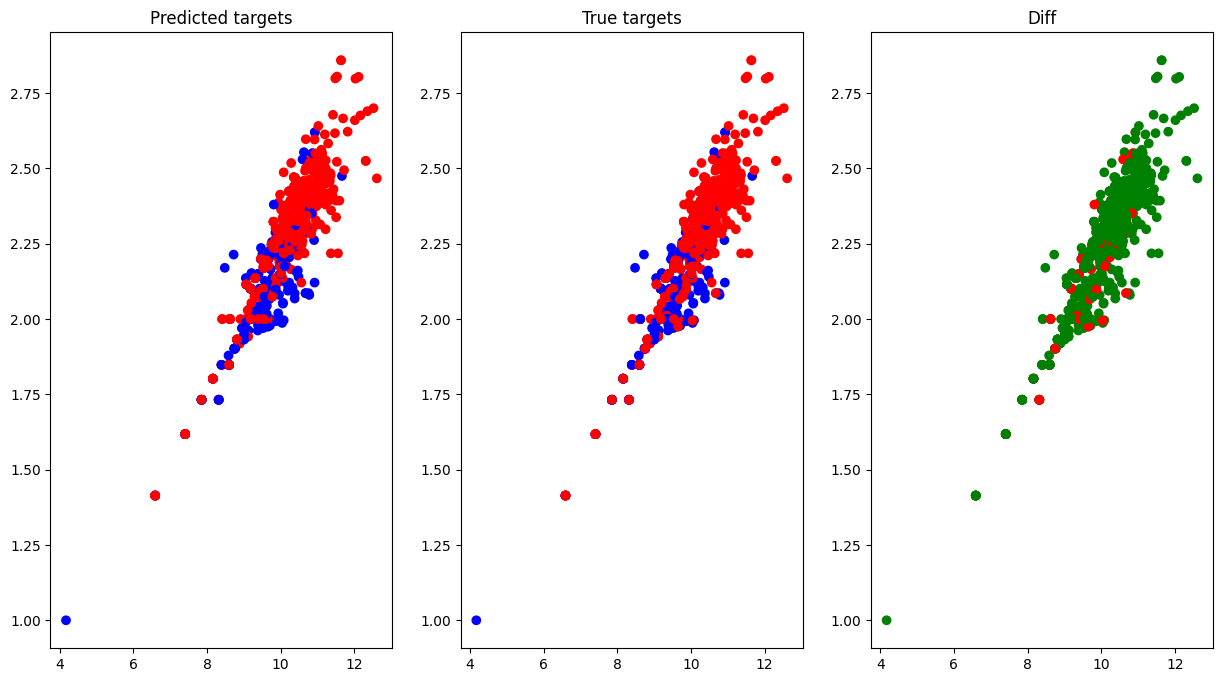

In [14]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

fig, ax = plt.subplots(1,3, figsize=(15,8))

features = ["V15", "V27"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

ax[0].scatter(x=df[features[0]], y=df[features[1]], c=predicted_colors) 
ax[0].set_title("Predicted targets")

ax[1].scatter(x=df[features[0]], y=df[features[1]], c=colors)
ax[1].set_title("True targets")

ax[2].scatter(x=df[features[0]], y=df[features[1]], c=diff_colors)
ax[2].set_title("Diff")

Points as predicted by KNN and colored by the actual target


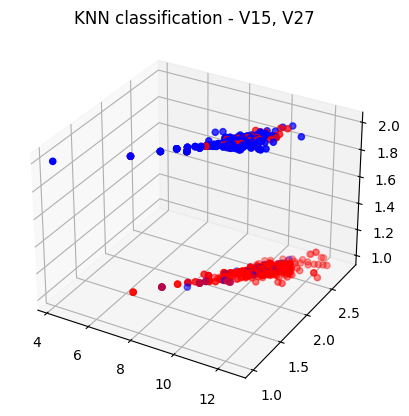

In [15]:
from mpl_toolkits.mplot3d import Axes3D

features = ["V15", "V27", "Class"]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"KNN classification - {features[0]}, {features[1]}")
print("Points as predicted by KNN and colored by the actual target")

### SVM - Support Vector Machine Model

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# https://scikit-learn.org/stable/modules/svm.html
class SupportVector:
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df
        
    def fit(self, kernel="linear", degree=2, gamma="auto"):
        # Get train and test data
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
        
        
        clf = SVC(kernel=kernel, degree=degree, gamma=gamma)
        clf.fit(X_train, y_train)
        
        accuracy = clf.score(X_test, y_test)
        
        return clf, accuracy

In [74]:
svm = SupportVector(df, df_test)
clf, svm_accuracy = svm.fit(kernel="linear")
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

SVM accuracy: 84.689%


Points as predicted by SVM and colored by the actual target


Text(0.5, 0.5, 'V27')

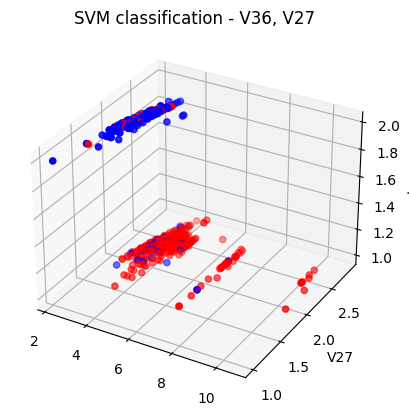

In [18]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])

features = ["V36", "V27", "Class"]

predicted_colors = ["red" if target == 1 else "blue" for target in prediction]
diff_colors = ["green" if predicted == target else "red" for target, predicted in zip(df["Class"], prediction)]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"SVM classification - {features[0]}, {features[1]}")
print("Points as predicted by SVM and colored by the actual target")
ax.set_zlabel("class")
ax.set_ylabel(features[1])

# Plot the seperating hyperplane - TODO
#hplane = clf.decision_function(df.loc[:, df.columns != "Class"])
#w = clf.coef_[0]
#a,b,c = -w[0] / w[1], -w[0] / w[2], -w[0] / w[3]
#
#xx = np.linspace(0, 14)
#yy = np.linspace(0, 14)
#XX, YY = np.meshgrid(xx, yy)
#ZZ = hplane#clf.decision_function()
#ZZ = ZZ.reshape(XX.shape)
#ax.plot_surface(XX, YY, ZZ, alpha=0.5, cmap='RdBu')

### Random forests

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html    
class RandomForest:
        def __init__(self, train_df, test_df):
            self.train_df = train_df
            self.test_df = test_df
            
        def fit(self, n_estimators=100, criterion="gini", max_depth=None):
            X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
            X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]
            
            clf = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth)
            clf.fit(X_train, y_train)
            
            accuracy = clf.score(X_test, y_test)
            
            return clf, accuracy

In [89]:
rf = RandomForest(df, df_test)
clf, rf_accuracy = rf.fit(n_estimators=200, criterion="log_loss", max_depth=10)

print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

Random Forest Classificator accuracy: 83.25%


In [21]:
test_colors = ["red" if c == 1 else "blue" for c in df_test["Class"]]

(209,)
Points as predicted by RF and colored by the actual target


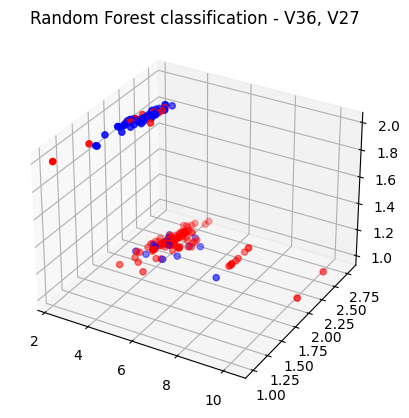

In [22]:
prediction = clf.predict(df_test.loc[:, df_test.columns != "Class"])
print(prediction.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(xs=df_test[features[0]], ys=df_test[features[1]], zs=prediction, c=test_colors)
ax.set_title(f"Random Forest classification - {features[0]}, {features[1]}")
print("Points as predicted by RF and colored by the actual target")


Text(0.5, 1.0, 'Importance of features returned by the random forest classifier')

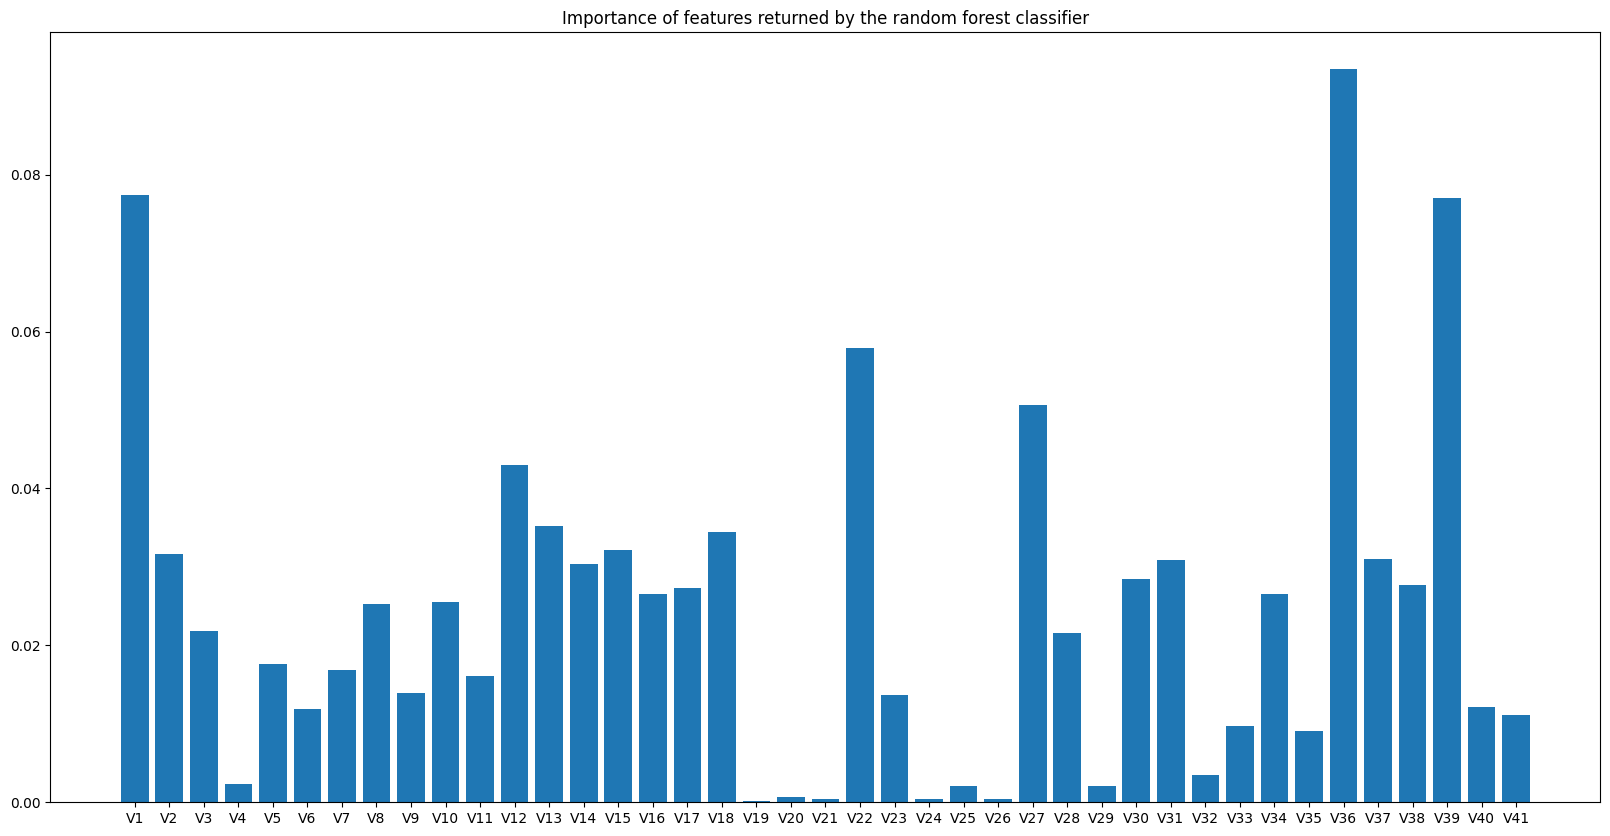

In [23]:
importances = clf.feature_importances_
features = df.columns
plt.figure(figsize=(20,10))
plt.bar(features[:-1], importances)
plt.title("Importance of features returned by the random forest classifier")

### LDA - Linear Discriminant Analysis

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

class LDA:
    def __init__(self, train, test):
        self.train_df = train
        self.test_df = test
        
    def fit(self, solver="svd", shrinkage="auto"):
        # Test train split
        X_train, y_train = self.train_df.loc[:, self.train_df.columns != "Class"], self.train_df["Class"]
        X_test, y_test = self.test_df.loc[:, self.test_df.columns != "Class"], self.test_df["Class"]

        clf = LinearDiscriminantAnalysis(solver=solver)
        clf = clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
       
        return clf, accuracy
       

In [107]:
lda = LDA(df, df_test)
clf, lda_accuracy = lda.fit(solver="lsqr")
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

LDA accuracy 80.86%


Points as predicted by KNN and colored by the actual target


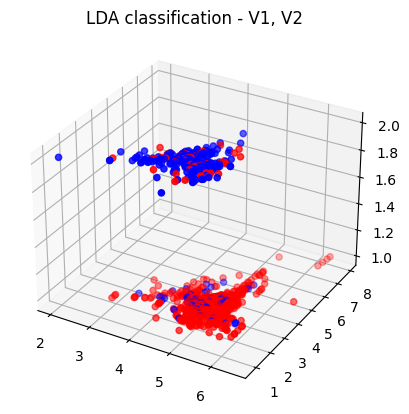

In [ ]:
prediction = clf.predict(df.loc[:, df.columns != "Class"])
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs=df[features[0]], ys=df[features[1]], zs=prediction, c=colors)
ax.set_title(f"LDA classification - {features[0]}, {features[1]}")
print("Points as predicted by KNN and colored by the actual target")


## Feature selection

In [109]:
from sklearn import feature_selection
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
X, y = df.loc[:, df.columns != "Class"], df["Class"]

In [ ]:
df_b = df.loc[:, df.columns != "Class"]
dft_b = df_test.loc[:, df_test.columns != "Class"]
df_norm=(df_b - df_b.mean()) / df_b.std()
dft_norm=(dft_b - dft_b.mean()) / dft_b.std()

colors2 = ["red" if c == 1 else "blue" for c in df_test["Class"]]
col = df.columns

In [ ]:
def remove_cor(df,df_test, threshold=.85):
    '''
        Returns train and test dataframe without the features with correlation above a given threshold
    '''
    corr = abs(df.corr(method="spearman"))

    corr = corr.unstack().sort_values(ascending=False)

    corr = corr.reset_index()
    corr.columns = ["feature1", "feature2", "corr"]

    displayed = set()
    rem = set()

    for i in range(len(corr)):
        pair = corr.iloc[i]
        if pair[0] and pair[1] and pair[0] != pair[1] and (pair[0], pair[1]) not in displayed and (pair[1], pair[0]) not in displayed:
            if pair[2] > threshold:
                displayed.add((pair[0], pair[1]))
                if (pair[0] not in rem and pair[1] not in rem):
                    rem.add(pair[0])

    drop_tr = df.drop(columns=list(rem))
    drop_t = df_test.drop(columns=list(rem))
    return drop_tr, drop_t

In [ ]:
print("DataFrame without features with high correlation!")

drop_tr, drop_t = remove_cor(df, df_test)

knn = KNeighbors(drop_tr, drop_t, 9)
clf, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(drop_tr, drop_t)
clf, svm_accuracy = svm.fit()
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(drop_tr, drop_t)
clf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(drop_tr, drop_t)
clf, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

DataFrame without features with high correlation!
KNN accuracy:  79.426%
SVM accuracy: 84.211%
Random Forest Classificator accuracy: 84.21%
LDA accuracy 84.21%


In [ ]:
def remove_low_var(df, df_test, threshold=.16):
    '''
        Removes features with variance below a given threshold
    '''
    selector = feature_selection.VarianceThreshold(threshold)
    selector.fit(df.loc[:, df.columns != "Class"])
    selcol = list(selector.get_support(indices=True))
    selcol.append(len(df.columns)-1)
    df_filtered = df[df.columns[selcol]]
    dft_filtered = df_test.loc[:,df_filtered.columns]
    return df_filtered, dft_filtered

In [112]:
print("DataFrame without features with high correlation and features with low variance!")

df_filtered, dft_filtered = remove_low_var(df, df_test)
df_filtered, dft_filtered = remove_cor(df_filtered, dft_filtered)

knn = KNeighbors(df_filtered, dft_filtered, 8)
clf_knn, knn_accuracy = knn.fit()
print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

svm = SupportVector(df_filtered, dft_filtered)
clf_svm, svm_accuracy = svm.fit(kernel="poly")
print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

rf_dr = RandomForest(df_filtered, dft_filtered)
clf_rf, rf_accuracy = rf.fit()
print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

lda = LDA(df_filtered, dft_filtered)
clf_lda, lda_accuracy = lda.fit()
print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")


DataFrame without features with high correlation and features with low variance!
KNN accuracy:  78.469%
SVM accuracy: 85.167%
Random Forest Classificator accuracy: 84.21%
LDA accuracy 82.3%


In [111]:
# VOTING CLASSIFIER

eclf = VotingClassifier(estimators=[('knn', clf_knn), ("rf", clf_rf), ("svm", clf_svm), ("lda", clf_lda)], voting="hard")
for clf, label in zip([clf_knn, clf_svm, clf_rf, clf_lda], ["KNN", "SVM", "RF", "LDA"]):
    scores = cross_val_score(clf, df_filtered.loc[:, df_filtered.columns != "Class"], df_filtered["Class"], scoring="accuracy")
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.81 (+/- 0.06) [KNN]
Accuracy: 0.85 (+/- 0.04) [SVM]
Accuracy: 0.86 (+/- 0.04) [RF]
Accuracy: 0.82 (+/- 0.04) [LDA]


#### Removing features with low variance

In [ ]:
comp = 23

knn_max = 0
xknn = 0
#6
rf_max = 0
xrf = 0
svm_max = 0
xsvm = 0
#23
lda_max = 0
xlda = 0
#30

for x in range(1):

    pca = PCA(n_components=comp)
    trPCA = pca.fit_transform(df_norm)
    trPCA = pd.DataFrame(trPCA, columns = col[:comp])
    trPCA.index = df.index
    trPCA["Class"] = df["Class"]
    tPCA = pca.transform(dft_norm)
    tPCA = pd.DataFrame(tPCA, columns = col[:comp])
    tPCA.index = df_test.index
    tPCA["Class"] = df_test["Class"]
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection="3d")
    #ax.scatter(xs=trPCA["V1"], ys=trPCA["V2"], zs=trPCA["V3"], c=colors)
    #ax.set_title(f"KNN classification - x, y")

    knnPCA = KNeighbors(trPCA, tPCA, 9)
    clf, knnPCA_accuracy = knnPCA.fit()
    #if knnPCA_accuracy > knn_max:
    #    knn_max = knnPCA_accuracy
    #    xknn = x
    print("KNN accuracy: ", str(round(knnPCA_accuracy*100, 3)) + "%")
    #print("KNN accuracy: ", str(round(knn_accuracy*100, 3)) + "%")

    rfPCA = RandomForest(trPCA, tPCA)
    clf, rfPCA_accuracy = rfPCA.fit()
    #if rfPCA_accuracy > rf_max:
    #    rf_max = rfPCA_accuracy
    #    xrf = x
    print("Random Forest Classificator accuracy:", str(round(rfPCA_accuracy*100, 3)) + "%")
    #print("Random Forest Classificator accuracy:", str(round(rf_accuracy*100, 2)) + "%")

    svmPCA = SupportVector(trPCA, tPCA)
    clf, svmPCA_accuracy = svmPCA.fit(kernel="linear", degree=2)
    #if svmPCA_accuracy > svm_max:
    #    svm_max = svmPCA_accuracy
    #    xsvm = x
    print("SVM accuracy:", str(round(svmPCA_accuracy*100, 3)) + "%")
    #print("SVM accuracy:", str(round(svm_accuracy*100, 3)) + "%")

    ldaPCA = LDA(trPCA, tPCA)
    clf, ldaPCA_accuracy = ldaPCA.fit()
    #if ldaPCA_accuracy > lda_max:
    #    lda_max = ldaPCA_accuracy
    #    xlda = x
    print("LDA accuracy", str(round(ldaPCA_accuracy*100, 3)) + "%")
    #print("LDA accuracy", str(round(lda_accuracy*100, 2)) + "%")

#print("KNN accuracy", str(round(knn_max*100, 2)) + "%")
#print(xknn)
#print("RF accuracy", str(round(rf_max*100, 2)) + "%")
#print(xrf)
#print("SVM accuracy", str(round(svm_max*100, 2)) + "%")
#print(xsvm)
#print("LDA accuracy", str(round(lda_max*100, 2)) + "%")
#print(xlda)



KNN accuracy:  83.254%
Random Forest Classificator accuracy: 84.689%
SVM accuracy: 86.124%
LDA accuracy 79.904%


#### Univariate feature selection